In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_raw = pd.read_csv('../../../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
df_raw['TotalCharges'] = pd.to_numeric(df_raw['TotalCharges'], errors='coerce')

In [4]:
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
#label encode Churn
#binary encode the yes/no
#one hot encode the rest

In [6]:
df_raw.columns = df_raw.columns.str.lower()

In [7]:
for col in df_raw.columns:
    print(col,df_raw[col].nunique())

customerid 7043
gender 2
seniorcitizen 2
partner 2
dependents 2
tenure 73
phoneservice 2
multiplelines 3
internetservice 3
onlinesecurity 3
onlinebackup 3
deviceprotection 3
techsupport 3
streamingtv 3
streamingmovies 3
contract 3
paperlessbilling 2
paymentmethod 4
monthlycharges 1585
totalcharges 6530
churn 2


In [8]:
cust_id = df_raw['customerid']
df = df_raw.drop('customerid',axis=1)

In [9]:
ord_encode = ['gender','partner','dependents','phoneservice','multiplelines','internetservice','onlinesecurity','onlinebackup',
              'deviceprotection','techsupport','streamingtv','streamingmovies','contract','paperlessbilling','paymentmethod']
labelencode =['churn']
num = ['seniorcitizen','tenure','monthlycharges','totalcharges']

In [10]:
X = df[ord_encode].join(df[num],how='left')
y = df[labelencode]



In [11]:
from sklearn.impute import SimpleImputer

impute = SimpleImputer(strategy='constant',fill_value=0)

X_imp = impute.fit_transform(X)
X_proc = pd.DataFrame(X_imp,columns=X.columns)


In [12]:
# from sklearn.preprocessing import OrdinalEncoder
# #ord encode categoticals
# ordi = OrdinalEncoder(dtype=np.int)

# X_proc = ordi.fit_transform(X_proc)
# X_enc = pd.DataFrame(X_proc,columns=X.columns)


In [13]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()

y_enc = lbl.fit_transform(np.array(y))

y_enc = pd.DataFrame(y_enc,columns=y.columns)

C:\Users\umbac\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [14]:
y_enc

,churn
0,0
1,0
2,1
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1


In [15]:
df_enc = X.join(y_enc,how='left')

In [53]:
df_raw['counter'] = 1
df_raw.groupby(by=['paymentmethod','churn']).sum()

seniorcitizen  tenure  monthlycharges  \
paymentmethod             churn                                          
Bank transfer (automatic) No               180   60623        83653.55   
                          Yes               53    6783        20091.90   
Credit card (automatic)   No               159   59471        83285.25   
                          Yes               62    6385        17946.60   
Electronic check          No               277   41584        96056.25   
                          Yes              317   17954        84288.75   
Mailed check              No                50   32709        53990.70   
                          Yes               44    2481        16803.60   

                                 totalcharges  counter  
paymentmethod             churn                         
Bank transfer (automatic) No       4162668.15     1286  
                          Yes       585611.75      258  
Credit card (automatic)   No       4126333.55     1290  
                          Yes       545259.80      232  
Electronic check          No       3377326.85     1294  
                          Yes      1567576.40     1071  
Mailed check              No       1526913.25     1304  
                          Yes       164478.95      308

In [60]:
churned = df_raw.loc[df_raw['churn'] == 'Yes']
not_churned = df_raw.loc[df_raw['churn'] == 'No']
plt.style.use('fivethirtyeight')

# fig1, ax = plt.subplots(figsize=(10,4))

# ax = plt.hist(x='paymentmethod',data=churned)
# plt.title('Did Churn')

In [59]:
# fig2, ax = plt.subplots(figsize=(10,4))

# ax = plt.hist(x='paymentmethod',data=not_churned)
# plt.title('Did not Churn')

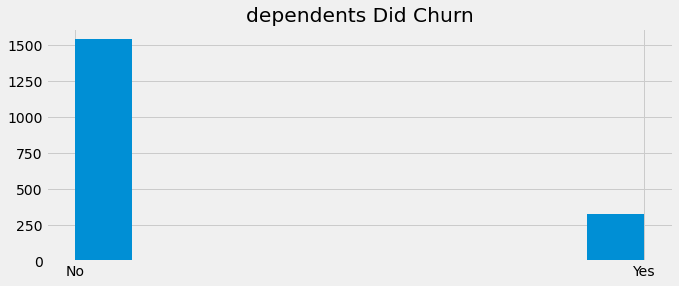

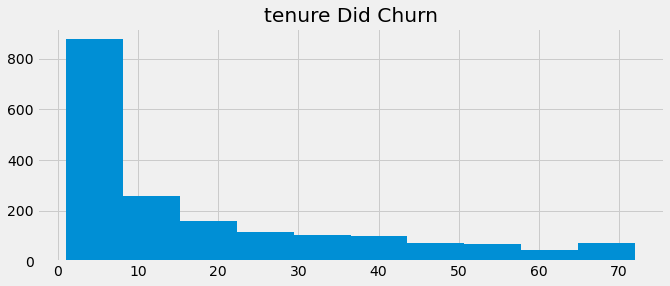

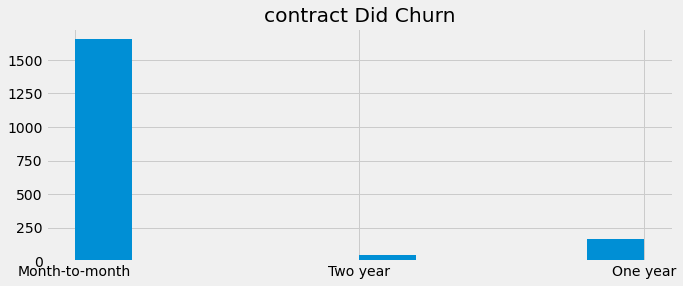

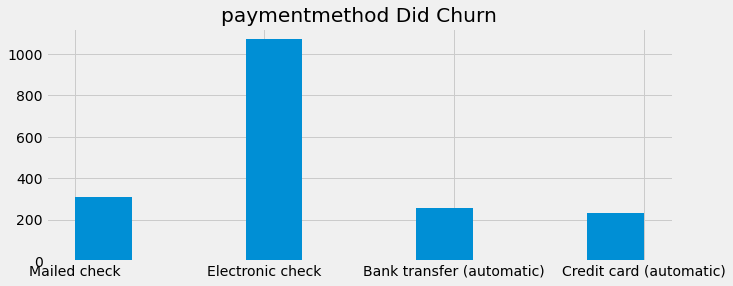

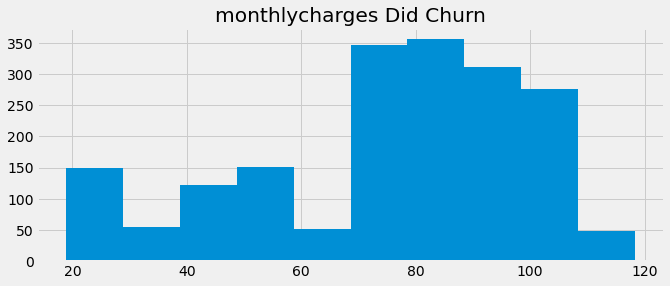

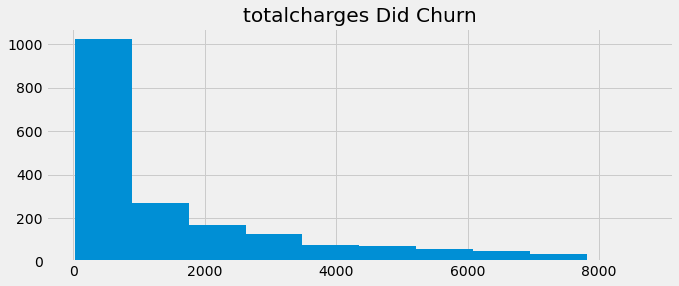

In [58]:
interesting_cols = ['dependents','tenure','contract','paymentmethod','monthlycharges','totalcharges']

for col in churned[interesting_cols]:
    fig, ax = plt.subplots(figsize=(10,4))

    ax = plt.hist(x=col,data=churned)
    plt.title(f'{col} Did Churn')
    


From these graphs, more people without dependents dropped their service. Also, those who hadn't been with the company long (tenure) dropped more. Most drops were month to month contracts and electronic checks. Additionally, people without a large total charge dropped more. This makes sense because people who had a low tenure wouldn't be able to get a lot of total charges.